# Importacion de librerias

In [1330]:
from math import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# PARTE 1

## A.

### Altura de las mareas del mes de Enero de 2021

Cargo el archivo que voy a utilizar

In [1331]:
ruta_del_archivo = "CO-OPS_8452660_met(1-2021).csv"
data = pd.read_csv(ruta_del_archivo)

Calculo el promedio de la altura de las mareas segun la hora del dia

In [1332]:
promedios_por_hora = data.groupby('Time (GMT)')['Verified (m)'].mean()
tiempos = promedios_por_hora.index

Grafico

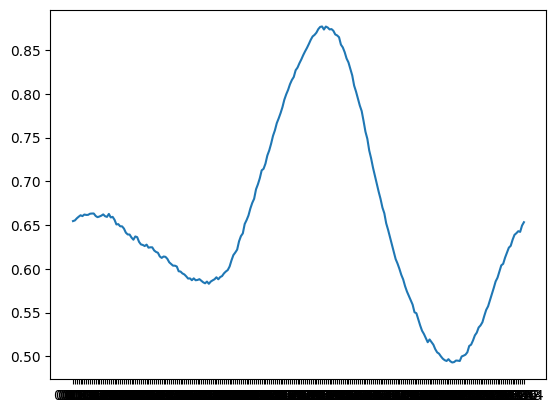

In [1333]:
plt.plot(tiempos,promedios_por_hora)
plt.show()

### Estimación del tiempo entre dos máximos consecutivos y/o dos mínimos consecutivos del mismo día. 

In [1334]:
fecha = '2021/01/01'

# Utiliza groupby() para agrupar por la columna 'Date' y luego get_group() para obtener los registros de la categoría deseada
registros_categoria_deseada = data.groupby('Date').get_group(fecha)

tiempos = registros_categoria_deseada['Time (GMT)'].tolist()
alturas = registros_categoria_deseada['Verified (m)'].tolist()

maximos = []
minimos = []

for i in range(0,len(alturas),1):
    if i == 0:
        if alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    elif i == (len(alturas)-1):
        if alturas[i] > alturas[i-1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    else:
        if alturas[i-1] < alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        elif alturas[i-1] > alturas[i] < alturas[i+1]:
            minimos.append(tiempos[i])

def tiempo_a_int(strings):
    nuevo_array=[]
    for tiempos in strings:
        horas, minutos = tiempos.split(':')
        horas = int(horas)
        minutos = int(minutos)
        minutos = minutos + horas * 60
        nuevo_array.append(minutos)
    return nuevo_array

def tiempo_a_strings(ints):
    tiempo = round(ints)
    horas = tiempo // 60
    minutos = tiempo % 60
    horas = str(horas)
    minutos = str(minutos)
    tiempo = horas + ':' + minutos
    return tiempo

def calculador_diferencias(tiempos):
    array_diferencias = []
    for i in range(0,len(tiempos)-1,1):
        diferencia = tiempos[i+1] - tiempos[i]
        array_diferencias.append(diferencia)
    return array_diferencias

tiempos_en_minutos_maximos = tiempo_a_int(maximos)
tiempos_en_minutos_minimos = tiempo_a_int(minimos)
diferencia_de_maximos = calculador_diferencias(tiempos_en_minutos_maximos)
diferencia_de_minimos = calculador_diferencias(tiempos_en_minutos_minimos)
promedio_diferencia_maximos = np.mean(diferencia_de_maximos)
promedio_diferencia_minimos = np.mean(diferencia_de_minimos)

print(tiempo_a_strings(promedio_diferencia_maximos))
print(tiempo_a_strings(promedio_diferencia_minimos))

0:49
0:45


## B.

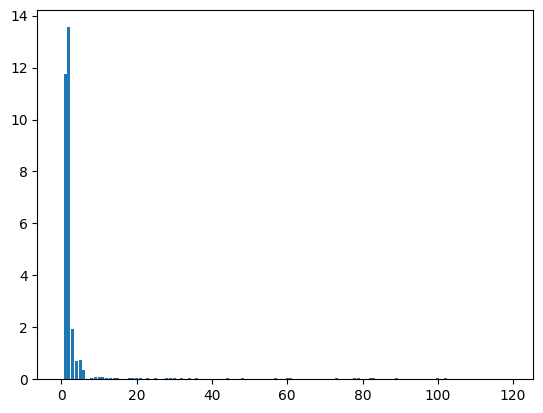

In [1335]:
transformada_fourier = abs(np.fft.fft(promedios_por_hora))
transformada_fourier[0]=0
mitad = transformada_fourier[:120]
x = np.arange(mitad.size)
plt.bar(x,mitad)
plt.show()

In [1336]:
frecuencia_mayor = np.argmax(transformada_fourier)
periodo = len(promedios_por_hora)/frecuencia_mayor
periodo

1.0084033613445378

Creo funciones necesarias para la resolucion del trabajo

In [1337]:
def pseudo_producto_escalar (vector1,vector2):
    resultado = 0
    for i in range(0,len(vector1),1):
        resultado = resultado + vector1[i] * vector2[i]
    return resultado

def calculador_pseudo_productos(fis):
    resultados = []
    iteraciones = 0
    for i in range(0,len(fis),1):
            for j in range(i,len(fis),1):
                resultados.append(pseudo_producto_escalar(fis[i],fis[j]))
    return resultados

#cantidad_fis es la cantidad de fis que tengo en la ecuacion mediante la cual quiero aproximar
def armador_matriz_fis(pseudo_productos,cantidad_fis):
    columnas = []
    for j in range(0,cantidad_fis,1):
        fila = []
        posicion = j
        ingresos = 0
        fila.append(pseudo_productos[posicion])
        ingresos = ingresos + 1
        
        if j != 0:
            for w in range(0,j,1):
                posicion = posicion+cantidad_fis-w
                fila.append(pseudo_productos[posicion])
                ingresos = ingresos + 1

        if cantidad_fis-ingresos != 0:
            for i in range(1,cantidad_fis-ingresos+1,1):
                fila.append(pseudo_productos[posicion+i])
        
        columnas.append(fila)
    matriz = np.matrix(columnas)
    return matriz

def armador_matriz_f(pseudo_productos,cantidad_fis):
    columnas = []
    posicion = 0
    for j in range(0,cantidad_fis,1):
        fila = []
        w=j-1
        if j <= 1:
            w=0
        posicion = posicion+cantidad_fis-w
        if posicion < len(pseudo_productos):
            fila.append(pseudo_productos[posicion])
        columnas.append(fila)
    matriz = np.matrix(columnas)
    return matriz

def armador_matriz_c(cantidad_fis):
    columnas = []
    for i in range(0,cantidad_fis,1):
        fila = []
        fila.append(0)
        columnas.append(fila)
    matriz = np.matrix(columnas)
    return matriz

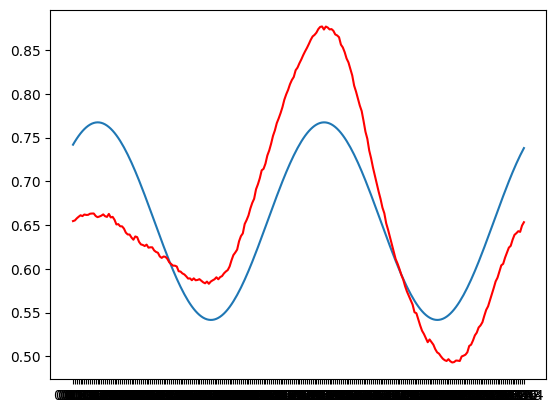

In [1338]:
frecuencia_angular = 2 * np.pi / len(promedios_por_hora)
interior_coseno = frecuencia_angular * frecuencia_mayor

fis = []
fi1 = []
fi2 = []
fi3 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno*i))
    fi3.append(np.sin(interior_coseno*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(promedios_por_hora)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,3)
matriz_f = armador_matriz_f(pseudo_productos,3)
matriz_c = armador_matriz_c(3)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,240,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno*i) + cs[2]*np.sin(interior_coseno*i))

f = np.squeeze(f)

plt.plot(x,f)
plt.plot(tiempos,promedios_por_hora, color="red")

## C.

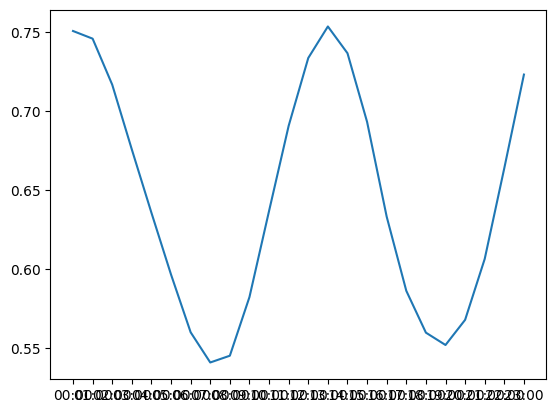

In [1339]:
ruta_del_archivo = "CO-OPS_8452660_met(2021).csv"
data = pd.read_csv(ruta_del_archivo)

promedios_por_hora = data.groupby('Time (GMT)')['Verified (m)'].mean()
tiempos = promedios_por_hora.index

plt.plot(tiempos, promedios_por_hora)
plt.show()

In [1340]:
fecha = '2021/01/01'

# Utilizo groupby() para agrupar por la columna 'Date' y luego get_group() para obtener los registros de la fecha deseada
registros_categoria_deseada = data.groupby('Date').get_group(fecha)

tiempos = registros_categoria_deseada['Time (GMT)'].tolist()
alturas = registros_categoria_deseada['Verified (m)'].tolist()

maximos = []
minimos = []

for i in range(0,len(alturas),1):
    if i == 0:
        if alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    elif i == (len(alturas)-1):
        if alturas[i] > alturas[i-1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    else:
        if alturas[i-1] < alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        elif alturas[i-1] > alturas[i] < alturas[i+1]:
            minimos.append(tiempos[i])

tiempos_en_minutos_maximos = tiempo_a_int(maximos)
tiempos_en_minutos_minimos = tiempo_a_int(minimos)
diferencia_de_maximos = calculador_diferencias(tiempos_en_minutos_maximos)
diferencia_de_minimos = calculador_diferencias(tiempos_en_minutos_minimos)
promedio_diferencia_maximos = np.mean(diferencia_de_maximos)
promedio_diferencia_minimos = np.mean(diferencia_de_minimos)

print(tiempo_a_strings(promedio_diferencia_maximos))
print(tiempo_a_strings(promedio_diferencia_minimos))

10:30
10:0


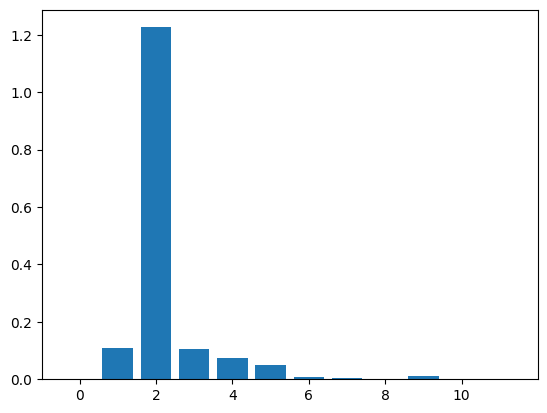

In [1341]:
transformada_fourier = abs(np.fft.fft(promedios_por_hora))
transformada_fourier[0]=0
mitad = transformada_fourier[:12]
x = np.arange(mitad.size)
plt.bar(x,mitad)
plt.show()

In [1342]:
frecuencia_mayor = np.argmax(transformada_fourier)
periodos = len(promedios_por_hora)/frecuencia_mayor
periodos

12.0

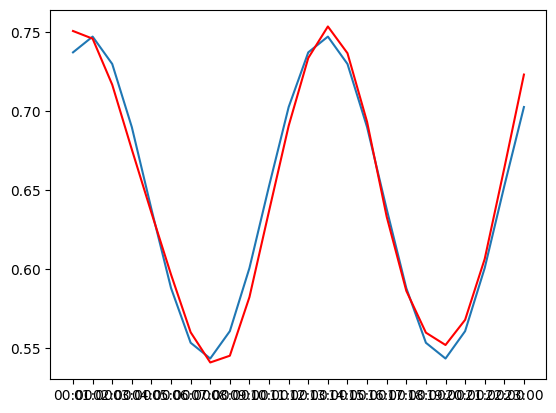

In [1343]:
frecuencia_angular = 2 * np.pi / len(promedios_por_hora)
interior_coseno = frecuencia_angular * frecuencia_mayor

fis = []
fi1 = []
fi2 = []
fi3 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno*i))
    fi3.append(np.sin(interior_coseno*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(promedios_por_hora)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,3)
matriz_f = armador_matriz_f(pseudo_productos,3)
matriz_c = armador_matriz_c(3)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,24,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno*i) + cs[2]*np.sin(interior_coseno*i))

f = np.squeeze(f)

plt.plot(x,f)
plt.plot(tiempos,promedios_por_hora, color="red")

## D.

### Enero

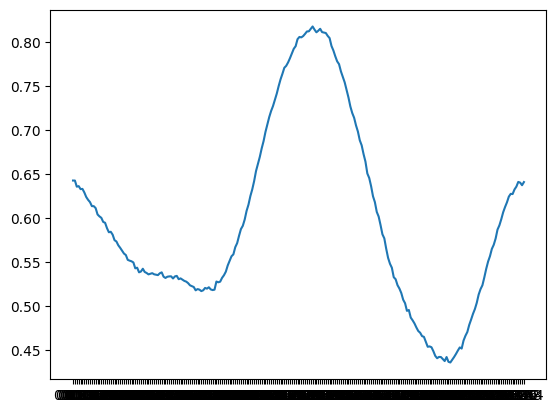

In [1344]:
ruta_del_archivo = "CO-OPS_8452660_met(1-2022).csv"
data = pd.read_csv(ruta_del_archivo)

promedios_por_hora = data.groupby('Time (GMT)')['Verified (m)'].mean()
tiempos = promedios_por_hora.index

plt.plot(tiempos, promedios_por_hora)
plt.show()

In [1345]:
fecha = '2022/01/01'

# Utiliza groupby() para agrupar por la columna 'Date' y luego get_group() para obtener los registros de la categoría deseada
registros_categoria_deseada = data.groupby('Date').get_group(fecha)

tiempos = registros_categoria_deseada['Time (GMT)'].tolist()
alturas = registros_categoria_deseada['Verified (m)'].tolist()

maximos = []
minimos = []

for i in range(0,len(alturas),1):
    if i == 0:
        if alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    elif i == (len(alturas)-1):
        if alturas[i] > alturas[i-1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    else:
        if alturas[i-1] < alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        elif alturas[i-1] > alturas[i] < alturas[i+1]:
            minimos.append(tiempos[i])

tiempos_en_minutos_maximos = tiempo_a_int(maximos)
tiempos_en_minutos_minimos = tiempo_a_int(minimos)
diferencia_de_maximos = calculador_diferencias(tiempos_en_minutos_maximos)
diferencia_de_minimos = calculador_diferencias(tiempos_en_minutos_minimos)
promedio_diferencia_maximos = np.mean(diferencia_de_maximos)
promedio_diferencia_minimos = np.mean(diferencia_de_minimos)

print(tiempo_a_strings(promedio_diferencia_maximos))
print(tiempo_a_strings(promedio_diferencia_minimos))

1:34
1:16


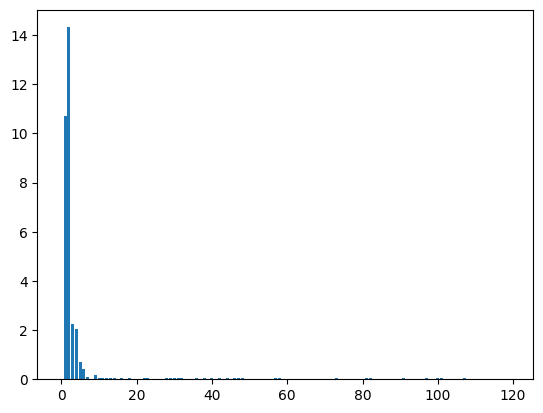

In [1346]:
transformada_fourier = abs(np.fft.fft(promedios_por_hora))
transformada_fourier[0]=0
mitad = transformada_fourier[:120]
x = np.arange(mitad.size)
plt.bar(x,mitad)
plt.show()

In [1347]:
frecuencia_mayor = np.argmax(transformada_fourier)
periodos = len(promedios_por_hora)/frecuencia_mayor
periodos

1.0084033613445378

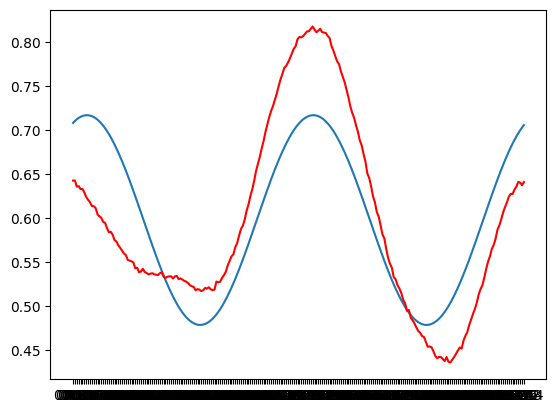

In [1348]:
frecuencia_angular = 2 * np.pi / len(promedios_por_hora)
interior_coseno = frecuencia_angular * frecuencia_mayor

fis = []
fi1 = []
fi2 = []
fi3 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno*i))
    fi3.append(np.sin(interior_coseno*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(promedios_por_hora)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,3)
matriz_f = armador_matriz_f(pseudo_productos,3)
matriz_c = armador_matriz_c(3)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,240,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno*i) + cs[2]*np.sin(interior_coseno*i))

f = np.squeeze(f)

plt.plot(x,f)
plt.plot(tiempos,promedios_por_hora, color="red")

### Todo el año

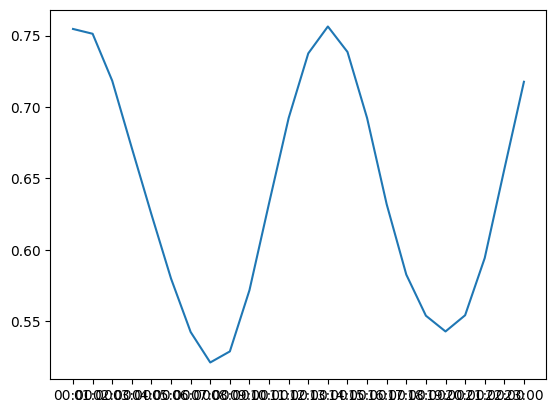

In [1349]:
ruta_del_archivo = "CO-OPS_8452660_met(2022).csv"
data = pd.read_csv(ruta_del_archivo)

promedios_por_hora = data.groupby('Time (GMT)')['Verified (m)'].mean()
tiempos = promedios_por_hora.index

plt.plot(tiempos, promedios_por_hora)
plt.show()

In [1350]:
fecha = '2022/01/01'

# Utiliza groupby() para agrupar por la columna 'Date' y luego get_group() para obtener los registros de la categoría deseada
registros_categoria_deseada = data.groupby('Date').get_group(fecha)

tiempos = registros_categoria_deseada['Time (GMT)'].tolist()
alturas = registros_categoria_deseada['Verified (m)'].tolist()

maximos = []
minimos = []

for i in range(0,len(alturas),1):
    if i == 0:
        if alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    elif i == (len(alturas)-1):
        if alturas[i] > alturas[i-1]:
            maximos.append(tiempos[i])
        else:
            minimos.append(tiempos[i])
    else:
        if alturas[i-1] < alturas[i] > alturas[i+1]:
            maximos.append(tiempos[i])
        elif alturas[i-1] > alturas[i] < alturas[i+1]:
            minimos.append(tiempos[i])

tiempos_en_minutos_maximos = tiempo_a_int(maximos)
tiempos_en_minutos_minimos = tiempo_a_int(minimos)
diferencia_de_maximos = calculador_diferencias(tiempos_en_minutos_maximos)
diferencia_de_minimos = calculador_diferencias(tiempos_en_minutos_minimos)
promedio_diferencia_maximos = np.mean(diferencia_de_maximos)
promedio_diferencia_minimos = np.mean(diferencia_de_minimos)

print(tiempo_a_strings(promedio_diferencia_maximos))
print(tiempo_a_strings(promedio_diferencia_minimos))

11:30
14:0


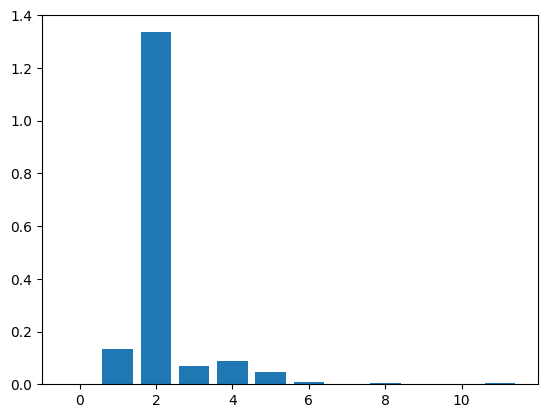

In [1351]:
transformada_fourier = abs(np.fft.fft(promedios_por_hora))
transformada_fourier[0]=0
mitad = transformada_fourier[:12]
x = np.arange(mitad.size)
plt.bar(x,mitad)
plt.show()

In [1352]:
frecuencia_mayor = np.argmax(transformada_fourier)
periodos = len(promedios_por_hora)/frecuencia_mayor
periodos

12.0

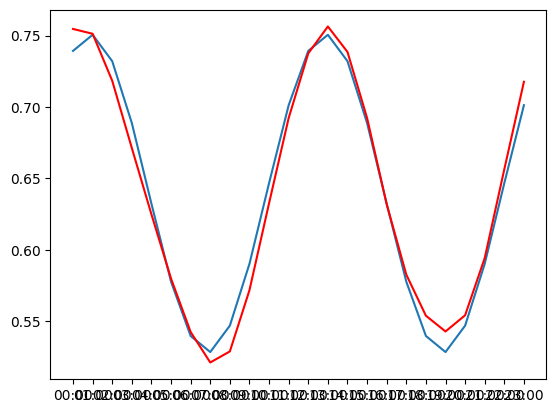

In [1353]:
frecuencia_angular = 2 * np.pi / len(promedios_por_hora)
interior_coseno = frecuencia_angular * frecuencia_mayor

fis = []
fi1 = []
fi2 = []
fi3 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno*i))
    fi3.append(np.sin(interior_coseno*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(promedios_por_hora)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,3)
matriz_f = armador_matriz_f(pseudo_productos,3)
matriz_c = armador_matriz_c(3)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,24,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno*i) + cs[2]*np.sin(interior_coseno*i))

f = np.squeeze(f)

plt.plot(x,f)
plt.plot(tiempos,promedios_por_hora, color="red")

# PARTE 2

## A.

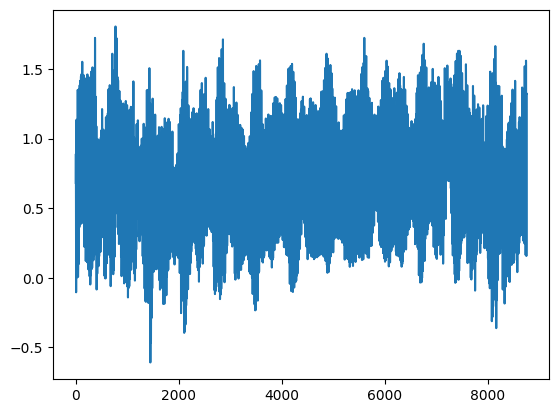

In [1354]:
ruta_del_archivo = "CO-OPS_8452660_met(2021).csv"
data = pd.read_csv(ruta_del_archivo)

alturas = data['Verified (m)']
tiempos = data['Time (GMT)']
tiempos1 = np.linspace(0,len(tiempos),len(tiempos))

plt.plot(tiempos1, alturas)
plt.show()

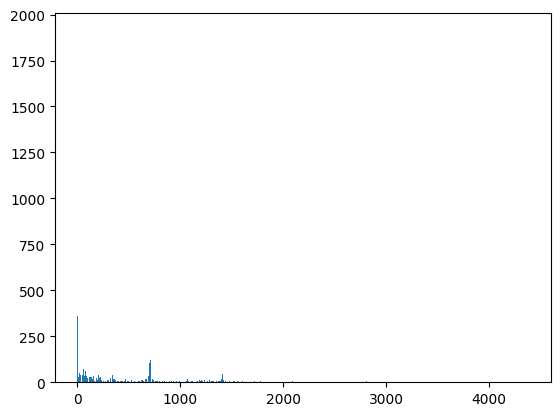

In [1355]:
transformada_fourier = abs(np.fft.fft(alturas))
transformada_fourier[0]=0
transformada_fourier = transformada_fourier[:4380]
x = np.arange(transformada_fourier.size)
plt.bar(x,transformada_fourier)
plt.show()

## B

In [1356]:
frecuencias_mayores = []
maximo = np.argmax(transformada_fourier)
transformada_fourier[maximo] = 0
maximo2 = np.argmax(transformada_fourier)
frecuencias_mayores.append(maximo)
frecuencias_mayores.append(maximo2)
periodos = []
periodos.append(len(alturas)/frecuencias_mayores[0])
periodos.append(len(alturas)/frecuencias_mayores[1])
print(periodos)

[12.425531914893616, 12.407932011331445]


459.5726227197305


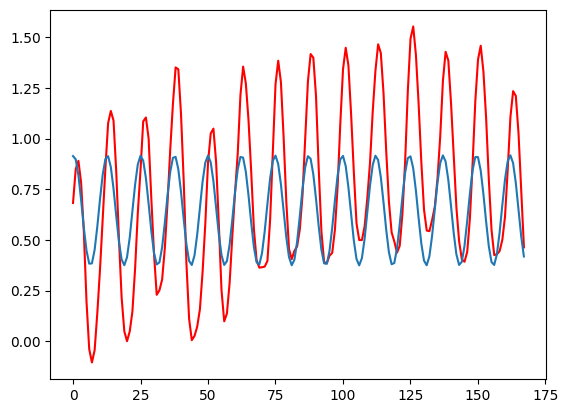

In [1357]:
frecuencia_angular = 2 * np.pi / len(alturas)
interior_coseno1 = frecuencia_angular * frecuencias_mayores[0]
interior_coseno2 = frecuencia_angular * frecuencias_mayores[1]

fis = []
fi1 = []
fi2 = []
fi3 = []
fi4 = []
fi5 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno1*i))
    fi3.append(np.sin(interior_coseno1*i))
    fi4.append(np.cos(interior_coseno2*i))
    fi5.append(np.sin(interior_coseno2*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(fi4)
fis.append(fi5)
fis.append(alturas)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,5)
matriz_f = armador_matriz_f(pseudo_productos,5)
matriz_c = armador_matriz_c(5)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i))

f = np.squeeze(f)

semana_alturas = alturas[:168]
semana_tiempos = tiempos1[:168]
semana_x = x[:168]
semana_f = f[:168]

np_alturas = np.array(alturas)
np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

## C

In [1358]:
transformada_fourier[maximo2] = 0
maximo3 = np.argmax(transformada_fourier)

frecuencias_mayores.append(maximo3)

389.00189484293253


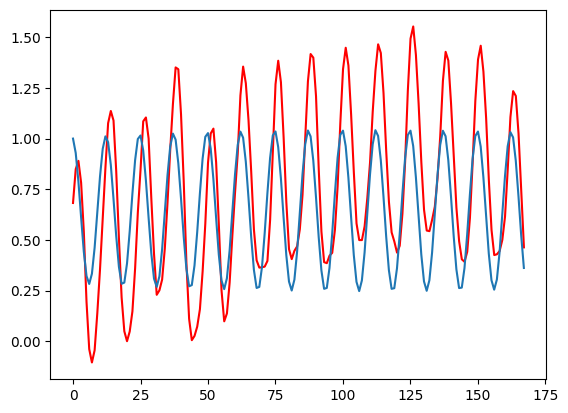

In [1359]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno3 = frecuencia_angular * frecuencias_mayores[2]

fi6 = []
fi7 = []
for i in range(0,len(tiempos),1):
    fi6.append(np.cos(interior_coseno3*i))
    fi7.append(np.sin(interior_coseno3*i))

fis = fis[:-1]
fis.append(fi6)
fis.append(fi7)
fis.append(alturas)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,7)
matriz_f = armador_matriz_f(pseudo_productos,7)
matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

In [1360]:
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo4 = np.argmax(transformada_fourier)

frecuencias_mayores.append(maximo4)

343.25216207158303


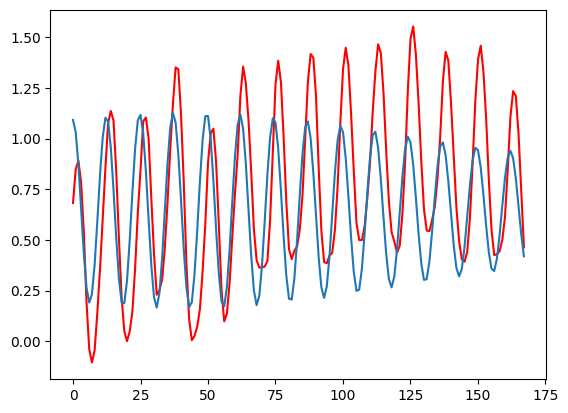

In [1361]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno4 = frecuencia_angular * frecuencias_mayores[3]

fi8 = []
fi9 = []
for i in range(0,len(tiempos),1):
    fi8.append(np.cos(interior_coseno4*i))
    fi9.append(np.sin(interior_coseno4*i))

fis = fis[:-1]
fis.append(fi8)
fis.append(fi9)
fis.append(alturas)


pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,9)
matriz_f = armador_matriz_f(pseudo_productos,9)

matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i) + cs[7]*np.cos(interior_coseno4*i) + cs[8]*np.sin(interior_coseno4*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

In [1362]:
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo5 = np.argmax(transformada_fourier)

frecuencias_mayores.append(maximo5)

307.2339067774682


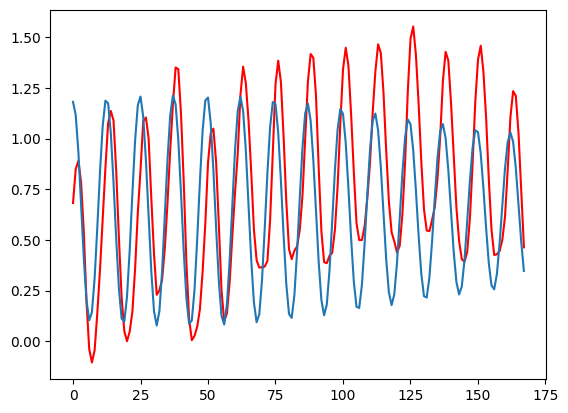

In [1363]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno5 = frecuencia_angular * frecuencias_mayores[4]

fi10 = []
fi11 = []
for i in range(0,len(tiempos),1):
    fi10.append(np.cos(interior_coseno5*i))
    fi11.append(np.sin(interior_coseno5*i))

fis = fis[:-1]
fis.append(fi10)
fis.append(fi11)
fis.append(alturas)


pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,11)
matriz_f = armador_matriz_f(pseudo_productos,11)

matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i) + cs[7]*np.cos(interior_coseno4*i) + cs[8]*np.sin(interior_coseno4*i) + cs[9]*np.cos(interior_coseno5*i) + cs[10]*np.sin(interior_coseno5*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

In [1364]:
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo6 = np.argmax(transformada_fourier)

frecuencias_mayores.append(maximo6)

277.59534953043703


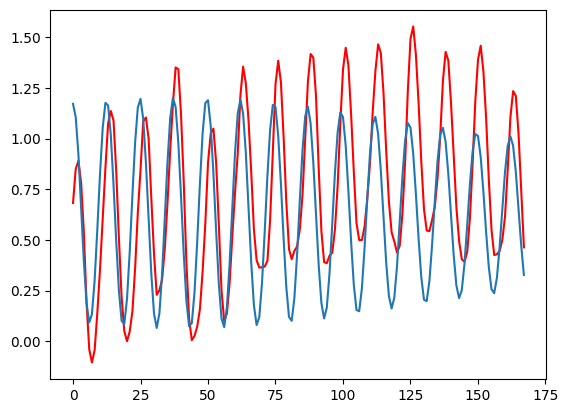

In [1365]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno6 = frecuencia_angular * frecuencias_mayores[5]

fi12 = []
fi13 = []
for i in range(0,len(tiempos),1):
    fi12.append(np.cos(interior_coseno6*i))
    fi13.append(np.sin(interior_coseno6*i))

fis = fis[:-1]
fis.append(fi12)
fis.append(fi13)
fis.append(alturas)


pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,13)
matriz_f = armador_matriz_f(pseudo_productos,13)

matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i) + cs[7]*np.cos(interior_coseno4*i) + cs[8]*np.sin(interior_coseno4*i) + cs[9]*np.cos(interior_coseno5*i) + cs[10]*np.sin(interior_coseno5*i) + cs[11]*np.cos(interior_coseno6*i) + cs[12]*np.sin(interior_coseno6*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

In [1366]:
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo7 = np.argmax(transformada_fourier)
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo8 = np.argmax(transformada_fourier)
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo9 = np.argmax(transformada_fourier)
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo10 = np.argmax(transformada_fourier)
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo11 = np.argmax(transformada_fourier)
indice_maximo = np.argmax(transformada_fourier)
transformada_fourier[indice_maximo] = 0
maximo12 = np.argmax(transformada_fourier)

frecuencias_mayores.append(maximo7)
frecuencias_mayores.append(maximo8)
frecuencias_mayores.append(maximo9)
frecuencias_mayores.append(maximo10)
frecuencias_mayores.append(maximo11)
frecuencias_mayores.append(maximo12)

197.46212123335337


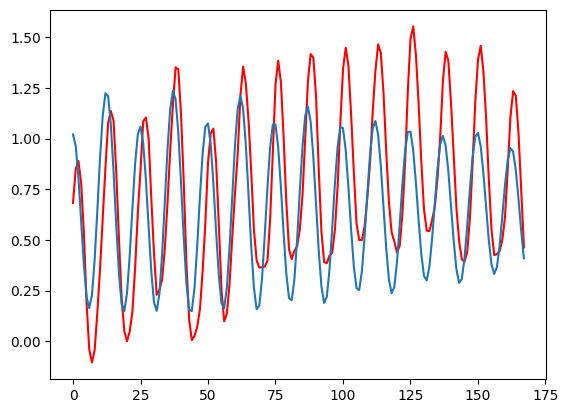

In [1367]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno7 = frecuencia_angular * frecuencias_mayores[6]
interior_coseno8 = frecuencia_angular * frecuencias_mayores[7]
interior_coseno9 = frecuencia_angular * frecuencias_mayores[8]
interior_coseno10 = frecuencia_angular * frecuencias_mayores[9]
interior_coseno11 = frecuencia_angular * frecuencias_mayores[10]
interior_coseno12 = frecuencia_angular * frecuencias_mayores[11]

fi14 = []
fi15 = []
fi16 = []
fi17 = []
fi18 = []
fi19 = []
fi20 = []
fi21 = []
fi22 = []
fi23 = []
fi24 = []
fi25 = []
for i in range(0,len(tiempos),1):
    fi14.append(np.cos(interior_coseno7*i))
    fi15.append(np.sin(interior_coseno7*i))
    fi16.append(np.cos(interior_coseno8*i))
    fi17.append(np.sin(interior_coseno8*i))
    fi18.append(np.cos(interior_coseno9*i))
    fi19.append(np.sin(interior_coseno9*i))
    fi20.append(np.cos(interior_coseno10*i))
    fi21.append(np.sin(interior_coseno10*i))
    fi22.append(np.cos(interior_coseno11*i))
    fi23.append(np.sin(interior_coseno11*i))
    fi24.append(np.cos(interior_coseno12*i))
    fi25.append(np.sin(interior_coseno12*i))

fis = fis[:-1]
fis.append(fi14)
fis.append(fi15)
fis.append(fi16)
fis.append(fi17)
fis.append(fi18)
fis.append(fi19)
fis.append(fi20)
fis.append(fi21)
fis.append(fi22)
fis.append(fi23)
fis.append(fi24)
fis.append(fi25)
fis.append(alturas)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,25)
matriz_f = armador_matriz_f(pseudo_productos,25)

matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i) + cs[7]*np.cos(interior_coseno4*i) + cs[8]*np.sin(interior_coseno4*i) + cs[9]*np.cos(interior_coseno5*i) + cs[10]*np.sin(interior_coseno5*i) + cs[11]*np.cos(interior_coseno6*i) + cs[12]*np.sin(interior_coseno6*i) + cs[13]*np.cos(interior_coseno7*i) + cs[14]*np.sin(interior_coseno7*i) + cs[15]*np.cos(interior_coseno8*i) + cs[16]*np.sin(interior_coseno8*i) + cs[17]*np.cos(interior_coseno9*i) + cs[18]*np.sin(interior_coseno9*i) + cs[19]*np.cos(interior_coseno10*i) + cs[20]*np.sin(interior_coseno10*i) + cs[21]*np.cos(interior_coseno11*i) + cs[22]*np.sin(interior_coseno11*i) + cs[23]*np.cos(interior_coseno12*i) + cs[24]*np.sin(interior_coseno12*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

## D

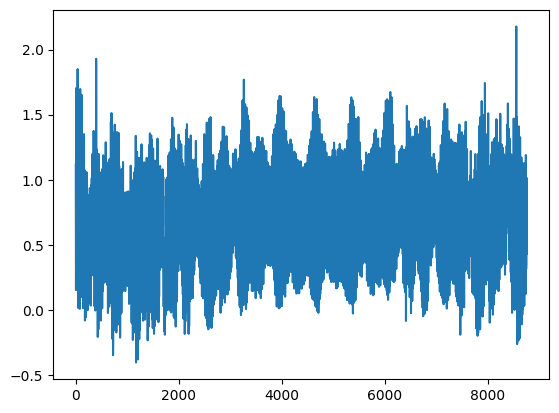

In [1368]:
ruta_del_archivo = "CO-OPS_8452660_met(2022).csv"
data = pd.read_csv(ruta_del_archivo)

alturas = data['Verified (m)']
tiempos = data['Time (GMT)']
tiempos1 = np.linspace(0,len(tiempos),len(tiempos))

plt.plot(tiempos1, alturas)
plt.show()

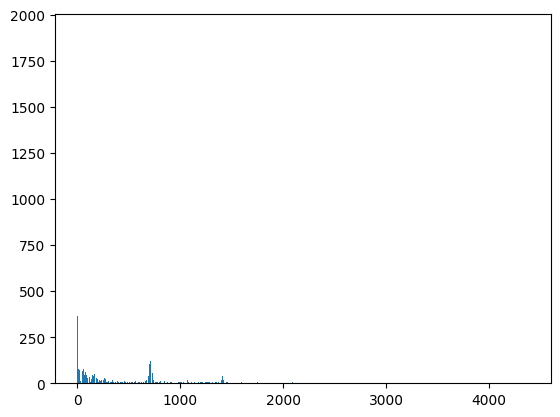

In [1369]:
transformada_fourier = abs(np.fft.fft(alturas))
transformada_fourier[0]=0
transformada_fourier = transformada_fourier[:4380]
x = np.arange(transformada_fourier.size)
plt.bar(x,transformada_fourier)
plt.show()

In [1370]:
frecuencias_mayores = []
maximo = np.argmax(transformada_fourier)
transformada_fourier[maximo] = 0
maximo2 = np.argmax(transformada_fourier)
frecuencias_mayores.append(maximo)
frecuencias_mayores.append(maximo2)
periodos = []
periodos.append(len(alturas)/frecuencias_mayores[0])
periodos.append(len(alturas)/frecuencias_mayores[1])
print(periodos)

[12.425531914893616, 12.407932011331445]


468.3669455062706


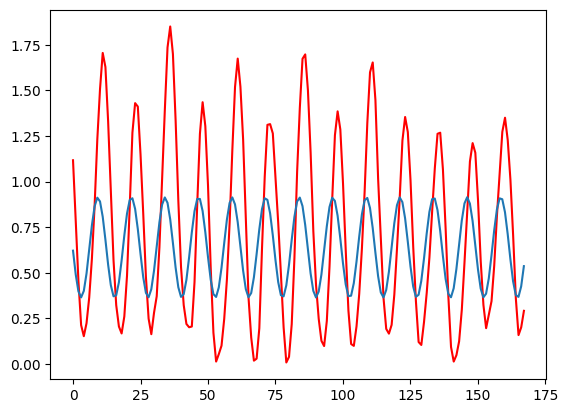

In [1371]:
frecuencia_angular = 2 * np.pi / len(alturas)
interior_coseno1 = frecuencia_angular * frecuencias_mayores[0]
interior_coseno2 = frecuencia_angular * frecuencias_mayores[1]

fis = []
fi1 = []
fi2 = []
fi3 = []
fi4 = []
fi5 = []
for i in range(0,len(tiempos),1):
    fi1.append(1)
    fi2.append(np.cos(interior_coseno1*i))
    fi3.append(np.sin(interior_coseno1*i))
    fi4.append(np.cos(interior_coseno2*i))
    fi5.append(np.sin(interior_coseno2*i))

fis.append(fi1)
fis.append(fi2)
fis.append(fi3)
fis.append(fi4)
fis.append(fi5)
fis.append(alturas)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,5)
matriz_f = armador_matriz_f(pseudo_productos,5)
matriz_c = armador_matriz_c(5)

inversa_matriz_fi = np.linalg.inv(matriz_fi)

matriz_c = inversa_matriz_fi * matriz_f

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i))

f = np.squeeze(f)

semana_alturas = alturas[:168]
semana_tiempos = tiempos1[:168]
semana_x = x[:168]
semana_f = f[:168]

np_alturas = np.array(alturas)
np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

In [1372]:
transformada_fourier[maximo2] = 0
maximo3 = np.argmax(transformada_fourier)
transformada_fourier[maximo3] = 0
maximo4 = np.argmax(transformada_fourier)
transformada_fourier[maximo4] = 0
maximo5 = np.argmax(transformada_fourier)
transformada_fourier[maximo5] = 0
maximo6 = np.argmax(transformada_fourier)
transformada_fourier[maximo6] = 0
maximo7 = np.argmax(transformada_fourier)
transformada_fourier[maximo7] = 0
maximo8 = np.argmax(transformada_fourier)
transformada_fourier[maximo8] = 0
maximo9 = np.argmax(transformada_fourier)
transformada_fourier[maximo9] = 0
maximo10 = np.argmax(transformada_fourier)
transformada_fourier[maximo10] = 0
maximo11 = np.argmax(transformada_fourier)
transformada_fourier[maximo11] = 0
maximo12 = np.argmax(transformada_fourier)
frecuencias_mayores.append(maximo3)
frecuencias_mayores.append(maximo4)
frecuencias_mayores.append(maximo5)
frecuencias_mayores.append(maximo6)
frecuencias_mayores.append(maximo7)
frecuencias_mayores.append(maximo8)
frecuencias_mayores.append(maximo9)
frecuencias_mayores.append(maximo10)
frecuencias_mayores.append(maximo11)
frecuencias_mayores.append(maximo12)

201.79515728538638


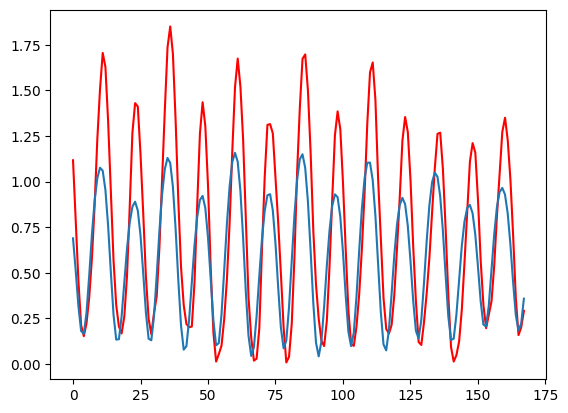

In [1373]:
frecuencia_angular = 2 * np.pi / len(tiempos)
interior_coseno3 = frecuencia_angular * frecuencias_mayores[2]
interior_coseno4 = frecuencia_angular * frecuencias_mayores[3]
interior_coseno5 = frecuencia_angular * frecuencias_mayores[4]
interior_coseno6 = frecuencia_angular * frecuencias_mayores[5]
interior_coseno7 = frecuencia_angular * frecuencias_mayores[6]
interior_coseno8 = frecuencia_angular * frecuencias_mayores[7]
interior_coseno9 = frecuencia_angular * frecuencias_mayores[8]
interior_coseno10 = frecuencia_angular * frecuencias_mayores[9]
interior_coseno11 = frecuencia_angular * frecuencias_mayores[10]
interior_coseno12 = frecuencia_angular * frecuencias_mayores[11]

fi6 = []
fi7 = []
fi8 = []
fi9 = []
fi10 = []
fi11 = []
fi12 = []
fi13 = []
fi14 = []
fi15 = []
fi16 = []
fi17 = []
fi18 = []
fi19 = []
fi20 = []
fi21 = []
fi22 = []
fi23 = []
fi24 = []
fi25 = []
for i in range(0,len(tiempos),1):
    fi6.append(np.cos(interior_coseno3*i))
    fi7.append(np.sin(interior_coseno3*i))
    fi8.append(np.cos(interior_coseno4*i))
    fi9.append(np.sin(interior_coseno4*i))
    fi10.append(np.cos(interior_coseno5*i))
    fi11.append(np.sin(interior_coseno5*i))
    fi12.append(np.cos(interior_coseno6*i))
    fi13.append(np.sin(interior_coseno6*i))
    fi14.append(np.cos(interior_coseno7*i))
    fi15.append(np.sin(interior_coseno7*i))
    fi16.append(np.cos(interior_coseno8*i))
    fi17.append(np.sin(interior_coseno8*i))
    fi18.append(np.cos(interior_coseno9*i))
    fi19.append(np.sin(interior_coseno9*i))
    fi20.append(np.cos(interior_coseno10*i))
    fi21.append(np.sin(interior_coseno10*i))
    fi22.append(np.cos(interior_coseno11*i))
    fi23.append(np.sin(interior_coseno11*i))
    fi24.append(np.cos(interior_coseno12*i))
    fi25.append(np.sin(interior_coseno12*i))

fis = fis[:-1]
fis.append(fi6)
fis.append(fi7)
fis.append(fi8)
fis.append(fi9)
fis.append(fi10)
fis.append(fi11)
fis.append(fi12)
fis.append(fi13)
fis.append(fi14)
fis.append(fi15)
fis.append(fi16)
fis.append(fi17)
fis.append(fi18)
fis.append(fi19)
fis.append(fi20)
fis.append(fi21)
fis.append(fi22)
fis.append(fi23)
fis.append(fi24)
fis.append(fi25)
fis.append(alturas)

pseudo_productos = calculador_pseudo_productos(fis)

matriz_fi = armador_matriz_fis(pseudo_productos,25)
matriz_f = armador_matriz_f(pseudo_productos,25)

matriz_c = np.linalg.solve(matriz_fi,matriz_f)

cs = np.array(matriz_c)

f = []
x = []
for i in range(0,8760,1):
    x.append(i)
    f.append(cs[0] + cs[1]*np.cos(interior_coseno1*i) + cs[2]*np.sin(interior_coseno1*i) + cs[3]*np.cos(interior_coseno2*i) + cs[4]*np.sin(interior_coseno2*i) + cs[5]*np.cos(interior_coseno3*i) + cs[6]*np.sin(interior_coseno3*i) + cs[7]*np.cos(interior_coseno4*i) + cs[8]*np.sin(interior_coseno4*i) + cs[9]*np.cos(interior_coseno5*i) + cs[10]*np.sin(interior_coseno5*i) + cs[11]*np.cos(interior_coseno6*i) + cs[12]*np.sin(interior_coseno6*i) + cs[13]*np.cos(interior_coseno7*i) + cs[14]*np.sin(interior_coseno7*i) + cs[15]*np.cos(interior_coseno8*i) + cs[16]*np.sin(interior_coseno8*i) + cs[17]*np.cos(interior_coseno9*i) + cs[18]*np.sin(interior_coseno9*i) + cs[19]*np.cos(interior_coseno10*i) + cs[20]*np.sin(interior_coseno10*i) + cs[21]*np.cos(interior_coseno11*i) + cs[22]*np.sin(interior_coseno11*i) + cs[23]*np.cos(interior_coseno12*i) + cs[24]*np.sin(interior_coseno12*i))

f = np.squeeze(f)

semana_x = x[:168]
semana_f = f[:168]

np_f = np.array(f)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)

# PARTE 3

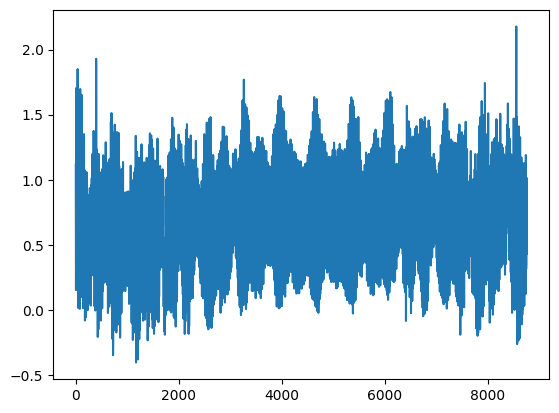

In [1374]:
ruta_del_archivo = "CO-OPS_8452660_met(2022).csv"
data = pd.read_csv(ruta_del_archivo)

alturas = data['Verified (m)']
tiempos = data['Time (GMT)']
tiempos1 = np.linspace(0,len(tiempos),len(tiempos))

plt.plot(tiempos1, alturas)
plt.show()

201.79515728538638


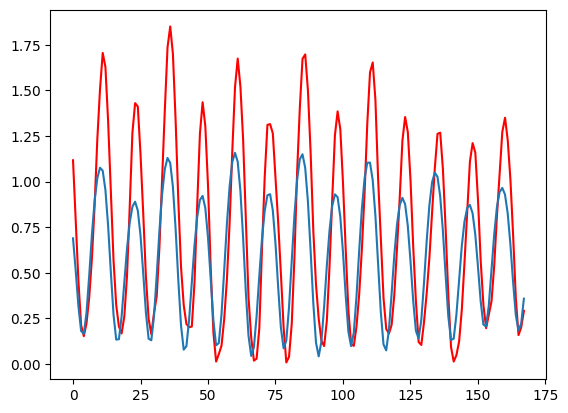

In [1375]:

semana_alturas = alturas[:168]
semana_tiempos = tiempos1[:168]

np_alturas = np.array(alturas)
diferencias_cuadradas = (np_alturas - np_f)**2
ECM = np.sum(diferencias_cuadradas)
print(ECM)

plt.plot(semana_tiempos,semana_alturas, color="red")
plt.plot(semana_x,semana_f)